In [ ]:
import pandas as pd
import numpy as np
import os
import shutil

In [ ]:
path = '/Users/ikea/Documents/DKU/STATS402/hateful_memes/'

In [ ]:
test_data = pd.read_json(path+'dev_seen.jsonl',lines=True)
dev_unseen_data= pd.read_json(path+'dev_unseen.jsonl',lines=True)
final_test_data=pd.read_json(path+'test_seen.jsonl',lines=True)
test_unseen_data=pd.read_json(path+'test_unseen.jsonl',lines=True)
train_data=pd.read_json(path+'train.jsonl',lines=True)

train_data = pd.concat([train_data,test_data])
train_data = pd.concat([train_data,dev_unseen_data])
train_data = pd.concat([train_data,final_test_data])
train_data = pd.concat([train_data,test_unseen_data])
train_data[:1492]

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
1487,92187,img/92187.png,0,don't let this group get you downs
1488,79032,img/79032.png,1,kids shouldn't run with scissors lesbians shou...
1489,85097,img/85097.png,1,woke up last night to find my tv floating acro...
1490,49861,img/49861.png,1,ready for the cupcake? wake up and smell the b...


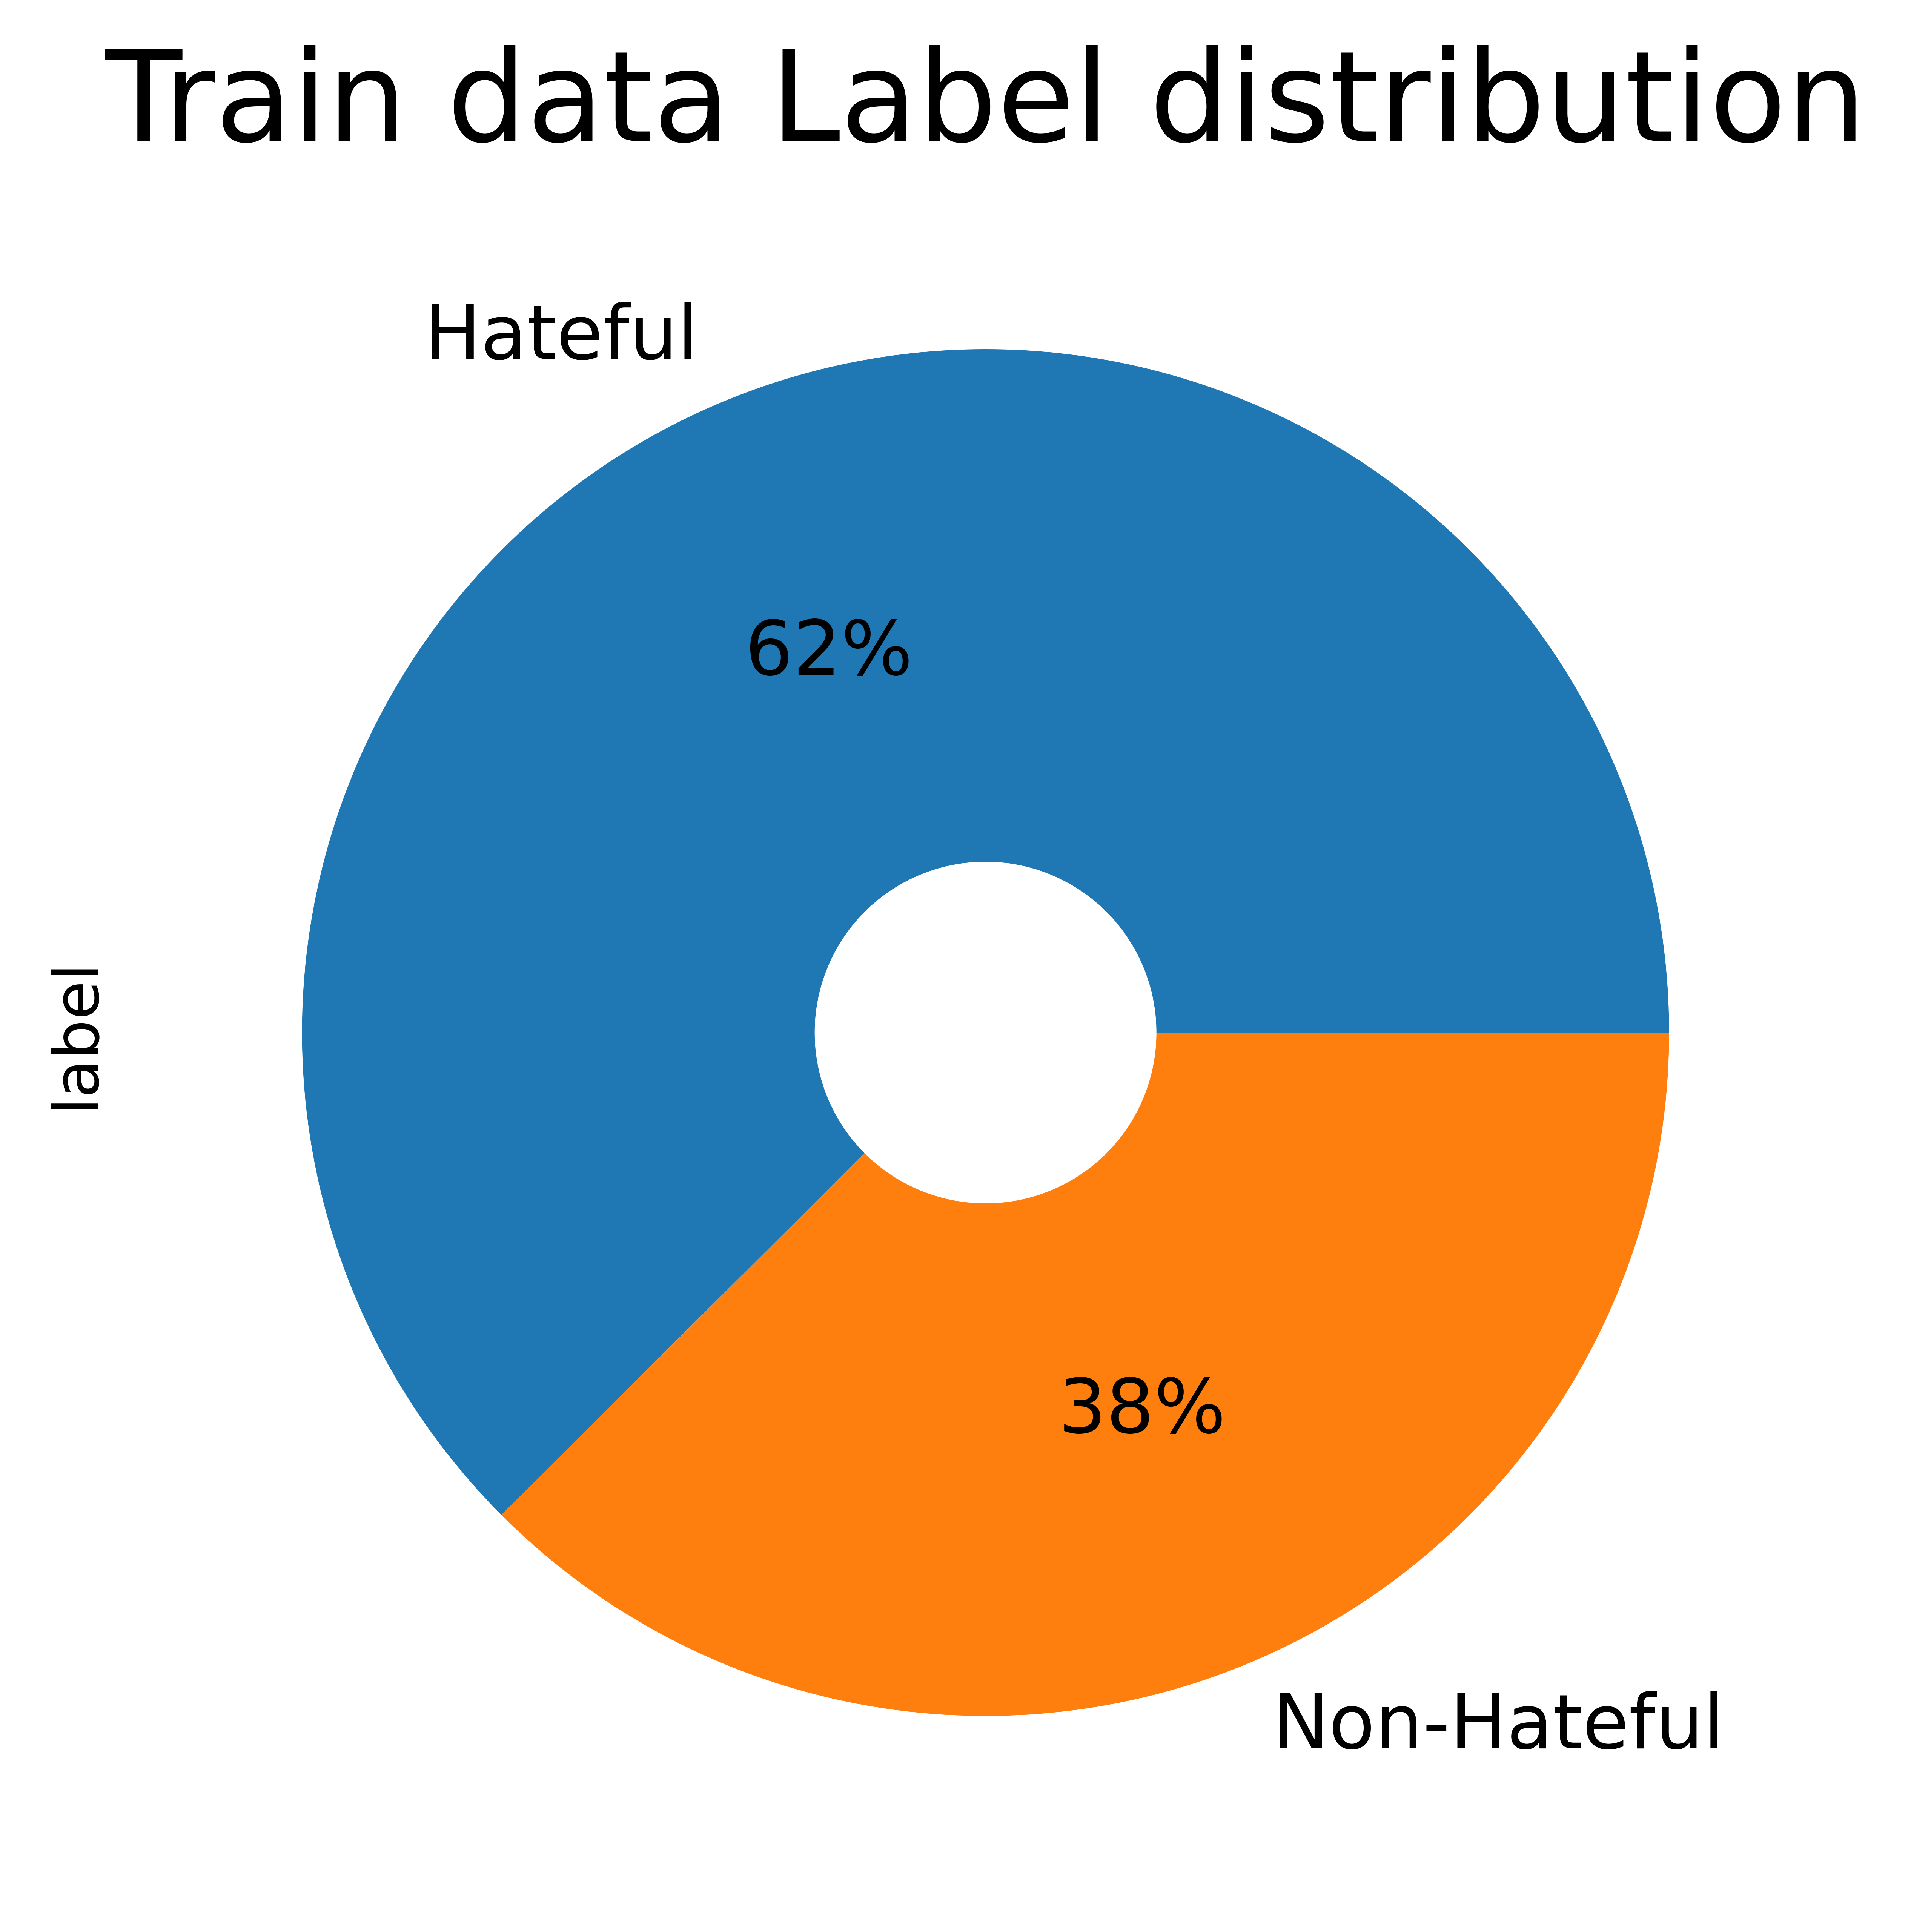

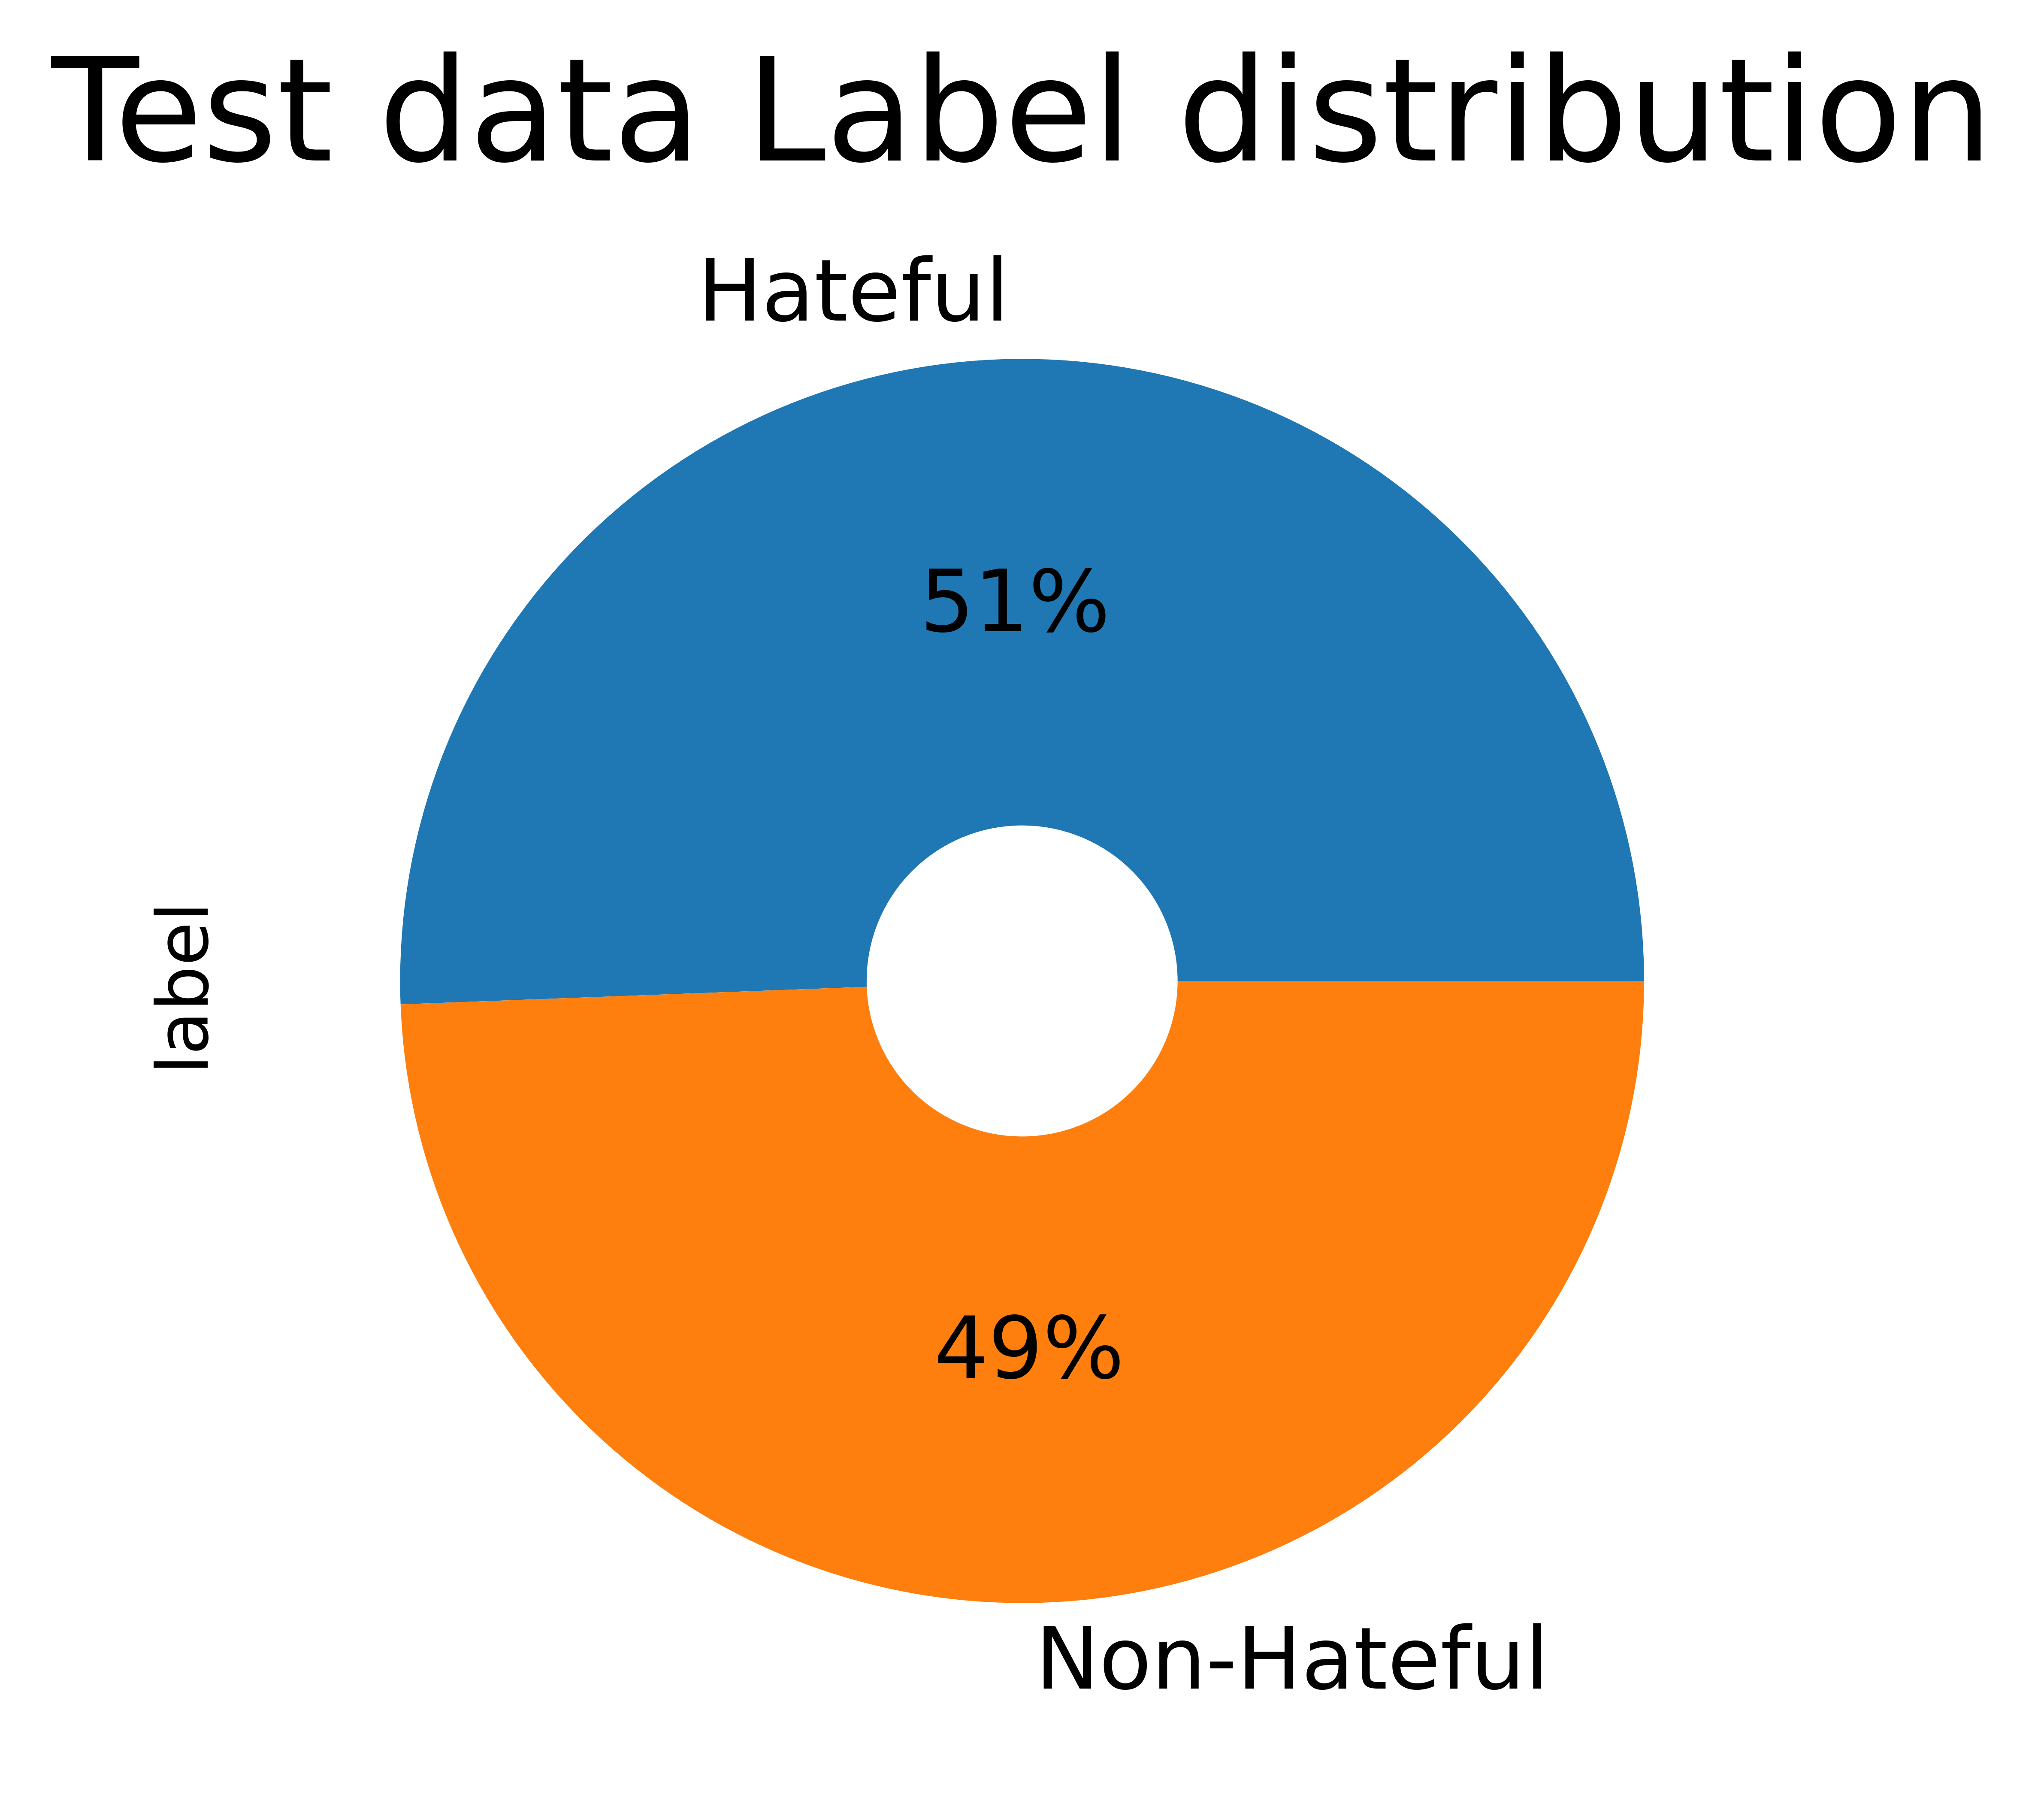

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Train data Label distribution', fontsize=20)
train_data.label.value_counts().plot(kind='pie', labels=['Hateful', 'Non-Hateful'],
                              wedgeprops=dict(width=.75), autopct='%1.0f%%', 
                              textprops={'fontsize': 12})
plt.show()
plt.title('Test data Label distribution', fontsize=20)
test_data.label.value_counts().plot(kind='pie', labels=['Hateful', 'Non-Hateful'],
                              wedgeprops=dict(width=.75), autopct='%1.0f%%', 
                              textprops={'fontsize': 12})
plt.show()

In [ ]:
from collections import Counter
with open("vocab.txt", 'w', encoding='utf-8') as fout:
    fout.write("<unk>\n")
    fout.write("<pad>\n")
    vocab = [word for word, freq in Counter(j for i in train_data["text"] for j in i).most_common() if freq>1]
    for i in vocab:
        fout.write(i+"\n")

In [ ]:
with open("vocab.txt", encoding='utf-8') as fin:
    vocab = [i.strip() for i in fin]
char2idx = {i:index for index, i in enumerate(vocab)}
idx2char = {index:i for index, i in enumerate(vocab)}
vocab_size = len(vocab)
pad_id = char2idx["<pad>"]
unk_id = char2idx["<unk>"]

In [ ]:
sequence_length = 385
def tokenizer():
    inputs = []
    sentence_char = [[j for j in i] for i in train_data["text"]]
    for index,i in enumerate(sentence_char):
        temp = [char2idx.get(j,unk_id) for j in i]
        if len(temp) < sequence_length:
            for _ in range(sequence_length-len(temp)):
                temp.append(pad_id)
        else:
            temp = temp[:sequence_length]
        inputs.append(temp)
    return inputs
data_input = tokenizer()

In [ ]:
myList = [2, 1, 3, 5, 1, 1, 1, 0]
valueToBeRemoved = 0

result = filter(lambda val: val !=  valueToBeRemoved, myList) 
print(list(result))

[2, 1, 3, 5, 1, 1, 1]


In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Embedding_size = 100
Batch_Size = 32
Kernel = 3
Filter_num = 10
Epoch = 30
Dropout = 0.5
Learning_rate = 1e-3

In [ ]:
class TextCNNDataSet(Data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.LongTensor(data_inputs)
        self.label = torch.LongTensor(data_targets)
        
    def __getitem__(self, index):
        return self.inputs[index], self.label[index] 
    
    def __len__(self):
        return len(self.inputs)
    
TextCNNDataSet = TextCNNDataSet(data_input, list(train_data["label"]))
train_size = int(len(data_input) * 0.8)
test_size = len(data_input) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(TextCNNDataSet, [train_size, test_size])

TrainDataLoader = Data.DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True)
TestDataLoader = Data.DataLoader(test_dataset, batch_size=Batch_Size, shuffle=True)

In [ ]:

num_classs = 2
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.W = nn.Embedding(vocab_size, embedding_dim=Embedding_size)
        out_channel = Filter_num
        self.conv = nn.Sequential(
                    nn.Conv2d(1, out_channel, (2, Embedding_size)),
                    nn.ReLU(),
                    nn.MaxPool2d((sequence_length-1,1)),
        )
        #self.dropout = nn.Dropout(Dropout)
        self.fc = nn.Linear(out_channel, num_classs)
    
    def forward(self, X):
        batch_size = X.shape[0]
        embedding_X = self.W(X) # [batch_size, sequence_length, embedding_size]
        embedding_X = embedding_X.unsqueeze(1) # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]
        conved = self.conv(embedding_X)# [batch_size, output_channel, 1, 1]
        #conved = self.dropout(conved)
        flatten = conved.view(batch_size, -1)# [batch_size, output_channel*1*1]
        output = self.fc(flatten)
        return output

In [ ]:
model = TextCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=Learning_rate)

In [ ]:
def binary_acc(pred, y):
    correct = torch.eq(pred, y).float()
    acc = correct.sum() / len(correct)
    return acc.item()

In [ ]:
def train():
    avg_acc = []
    predtrain = np.array([])
    y_train = np.array([])
    model.train()
    for index, (batch_x, batch_y) in enumerate(TrainDataLoader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred1 = model(batch_x)
        loss = criterion(pred1, batch_y)
        acc = binary_acc(torch.max(pred1, dim=1)[1], batch_y)
        avg_acc.append(acc)
        predtrain = np.append(predtrain, torch.max(pred1, dim=1)[1].detach().cpu().numpy())
        y_train = np.append(y_train, batch_y.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_acc = np.array(avg_acc).mean()
    return avg_acc,y_train,predtrain

In [ ]:
def evaluate():
    avg_acc = []
    prediction = np.array([])
    y_test = np.array([]) 
    model.eval()  
    with torch.no_grad():
        for x_batch, y_batch in TestDataLoader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            acc = binary_acc(torch.max(pred, dim=1)[1], y_batch)
            avg_acc.append(acc)
            prediction = np.append(prediction, torch.max(pred, dim=1)[1].detach().cpu().numpy())
            y_test = np.append(y_test, y_batch.detach().cpu().numpy())
    return np.array(avg_acc).mean(),y_test.flatten(),prediction.flatten()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
evaluate()

(0.634920637522425,
 array([1., 1., 0., ..., 0., 1., 0.]),
 array([1., 0., 0., ..., 1., 0., 1.]))

In [ ]:
_,y_train,predtrain = train()
print(_)

0.6414211783439491


In [ ]:
_, y_test,prediction = evaluate()
print(_)

0.6310654010953782


In [ ]:
len(y_test)

2508

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
auc_score = roc_auc_score(y_test,prediction)
LR_matrix = confusion_matrix(y_test,prediction)
print(LR_matrix)
print(auc_score)
print(metrics.classification_report(prediction, y_test))

[[1156  420]
 [ 506  426]]
0.5952920415677219
              precision    recall  f1-score   support

         0.0       0.73      0.70      0.71      1662
         1.0       0.46      0.50      0.48       846

    accuracy                           0.63      2508
   macro avg       0.60      0.60      0.60      2508
weighted avg       0.64      0.63      0.63      2508



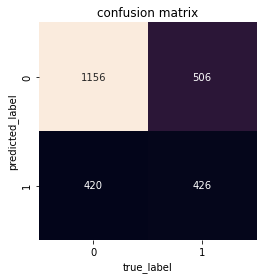

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.heatmap(LR_matrix .T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true_label')
plt.ylabel('predicted_label')
plt.title("confusion matrix");

In [ ]:

cnn_train_acc, cnn_test_acc = [], []

for epoch in range(1, Epoch+1):
    train_acc,y_train,predtrain = train()
    print('epoch={},Training accuracy={}'.format(epoch, train_acc))
    test_acc,y_test,prediction = evaluate()
    print("epoch={},Testing accuracy={}".format(epoch, test_acc))
    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)

NameError: ignored

Text(0.5, 1.0, 'ROC For Text-CNN')

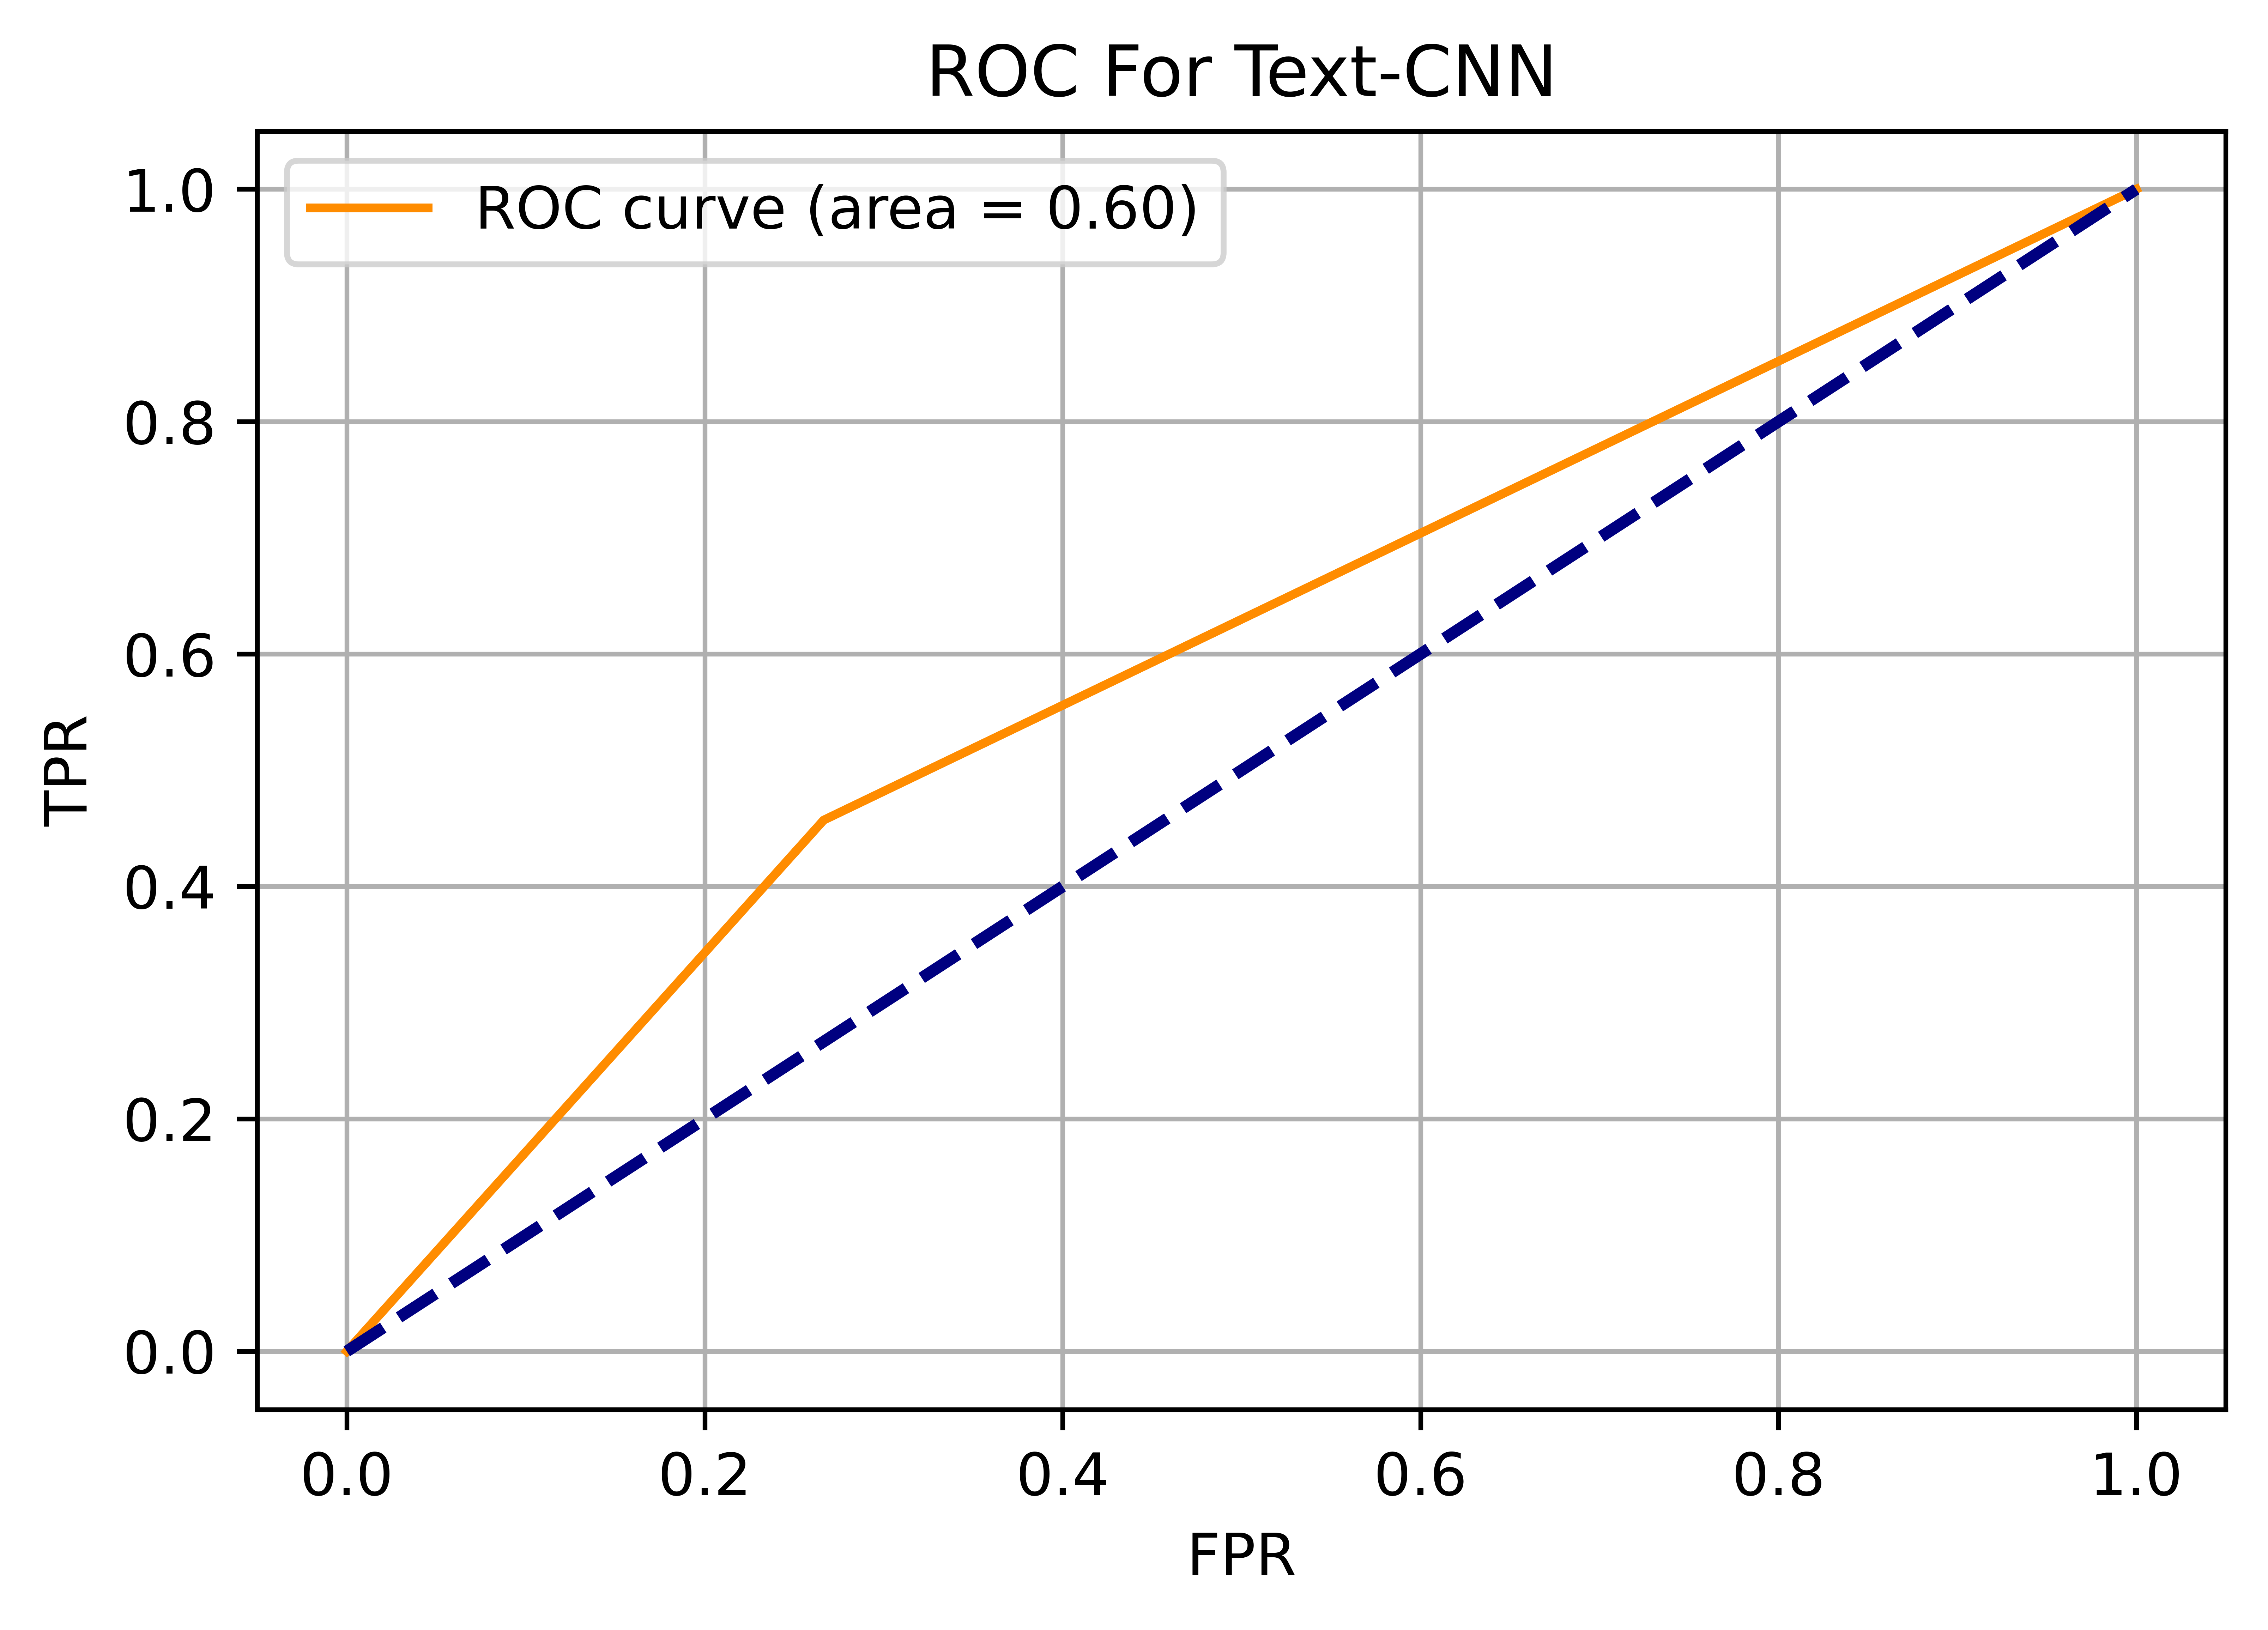

In [ ]:
# Create the roc curve
test_fpr, test_tpr, a = roc_curve(y_test, prediction, pos_label = 1)
train_fpr, train_tpr, b = roc_curve(y_train, predtrain, pos_label = 1)

# Create a dataframe of fpr and tpr to create visual
testRocDf = pd.DataFrame({'fpr': test_fpr, 'tpr': test_tpr, 'data':['test']*len(test_tpr)})
trainRocDf = pd.DataFrame({'fpr': train_fpr, 'tpr': train_tpr, 'data': ['train'] * len(train_tpr)})
rocDf = pd.concat([testRocDf, trainRocDf])
plt.rcParams['figure.dpi'] = 1200
#plt.plot(trainRocDf['fpr'], trainRocDf['tpr'],label = 'train')
plt.plot(testRocDf['fpr'], testRocDf['tpr'],label='ROC curve (area = %0.2f)' % auc_score,color='darkorange',)
plt.legend()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC For Text-CNN')

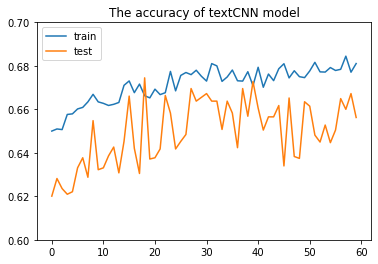

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cnn_train_acc)
plt.plot(cnn_test_acc)

plt.ylim(ymin=0.6, ymax=0.7)
plt.title("The accuracy of textCNN model")
plt.legend(["train", 'test'])
plt.show()